## Data Preprocessing

In [8]:
import pandas as pd
import numpy as np

# Load data
INES_df = pd.read_csv('INES_corrected_5yrs.csv')

# Convert date and ensure numeric types
INES_df['date'] = pd.to_datetime(INES_df['date'])
INES_df['P_measured'] = pd.to_numeric(INES_df['P_measured'], errors='coerce')
INES_df['Gsw'] = pd.to_numeric(INES_df['Gsw'], errors='coerce')
INES_df['T_air'] = pd.to_numeric(INES_df['T_air'], errors='coerce')
INES_df['T_PV'] = pd.to_numeric(INES_df['T_PV'], errors='coerce')
INES_df['hour'] = pd.to_numeric(INES_df['hour'], errors='coerce')
INES_df['date'] = pd.to_numeric(INES_df['date'], errors='coerce')


# Fill missing values
INES_df.fillna({'Gsw': INES_df['Gsw'].mean(), 'T_air': INES_df['T_air'].mean(), 'T_PV': INES_df['T_PV'].mean()}, inplace=True)
INES_df['P_measured'].fillna(method='ffill', inplace=True)

# Temperature adjustment using TC_P = -0.30% / °C
T_ref = 25.0  # STC reference temperature
TC_P = -0.003  # Temperature coefficient (-0.30% / °C)
delta_T = INES_df['T_PV'] - T_ref
INES_df['P_adjusted'] = INES_df['P_measured'] / (1 + TC_P * delta_T)

# Filter 1: Remove non-operational periods (zeros at night or with zero irradiance)
night_hours = (INES_df['hour'] >= 20) | (INES_df['hour'] <= 4)
INES_filtered = INES_df[~((INES_df['P_adjusted'] == 0) & (night_hours | (INES_df['Gsw'] == 0)))].copy()

# Filter 2: Outlier removal using IQR with upper cap at 3000 W
Q1 = INES_filtered['P_adjusted'].quantile(0.25)
Q3 = INES_filtered['P_adjusted'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = max(0, Q1 - 1.5 * IQR)
upper_bound = min(Q3 + 1.5 * IQR, 3000)  # Cap at 3000 W
INES_filtered = INES_filtered[(INES_filtered['P_adjusted'] >= lower_bound) & (INES_filtered['P_adjusted'] <= upper_bound)].copy()

# Filter 3: Handle repetitive values (stuck sensor detection)
INES_filtered['P_diff'] = INES_filtered['P_adjusted'].diff().abs()
rolling_const = INES_filtered['P_diff'].rolling(window=4, min_periods=1).std() == 0
INES_filtered = INES_filtered[~rolling_const].copy()

# Drop auxiliary columns
INES_filtered.drop(columns=['P_diff'], inplace=True)

# Save filtered dataset
INES_filtered.to_csv('INES_filtered_new.csv', index=False)

C:\Users\SM275008\AppData\Local\Temp\ipykernel_1116\2156376908.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  INES_df['P_measured'].fillna(method='ffill', inplace=True)
C:\Users\SM275008\AppData\Local\Temp\ipykernel_1116\2156376908.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  INES_df['P_measured'].fillna(method='ffill', inplace=True)


## PI-GAT model and architecture

Using device: cuda
Created 48 sliding windows.
Initializing model for 5-Year Continual Learning...
Starting training loop...

--- Processing Window 1/48 ---

--- Processing Window 2/48 ---
Early stopping at epoch 29

--- Processing Window 3/48 ---
Early stopping at epoch 16

--- Processing Window 4/48 ---

--- Processing Window 5/48 ---
Early stopping at epoch 12

--- Processing Window 6/48 ---
Early stopping at epoch 12

--- Processing Window 7/48 ---
Early stopping at epoch 17

--- Processing Window 8/48 ---
Early stopping at epoch 13

--- Processing Window 9/48 ---
Early stopping at epoch 22

--- Processing Window 10/48 ---

--- Processing Window 11/48 ---
Early stopping at epoch 14

--- Processing Window 12/48 ---
Early stopping at epoch 45

--- Processing Window 13/48 ---
Early stopping at epoch 12

--- Processing Window 14/48 ---
Early stopping at epoch 39

--- Processing Window 15/48 ---
Early stopping at epoch 29

--- Processing Window 16/48 ---

--- Processing Window 17/48 ---

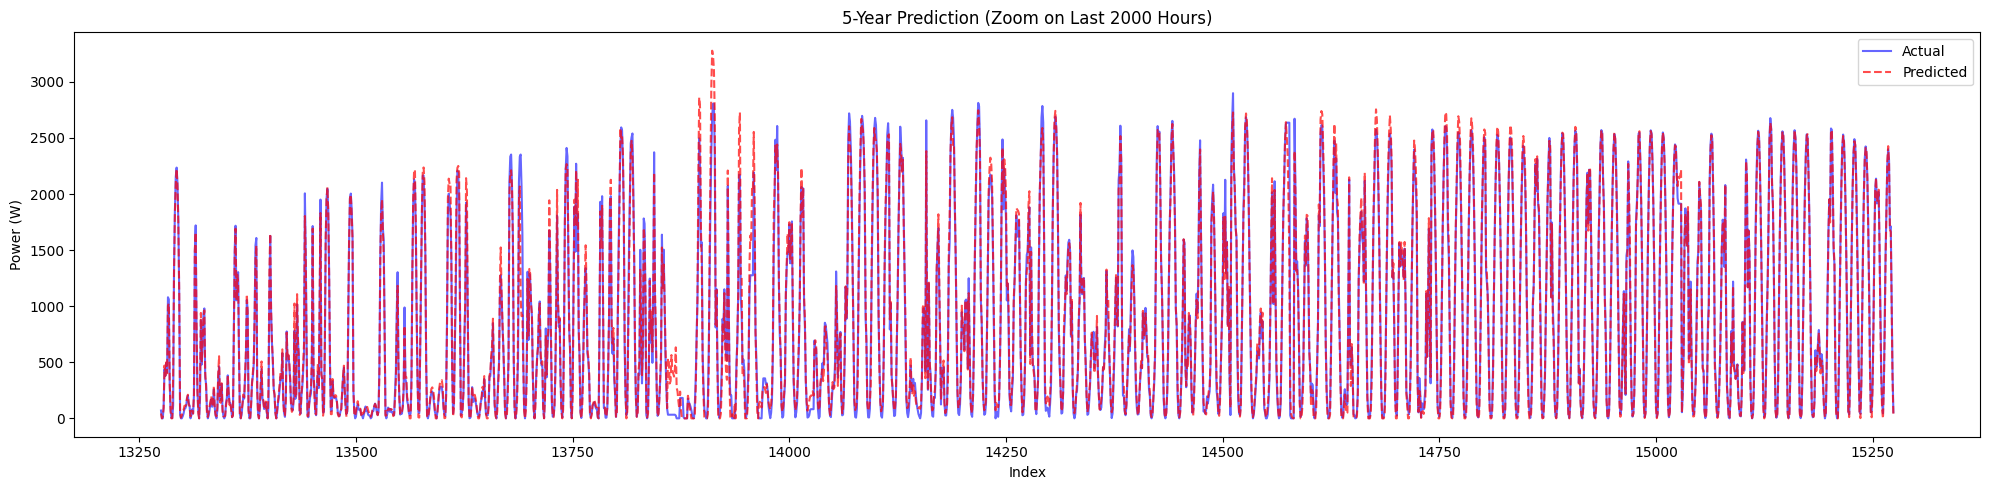

In [28]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from dateutil.relativedelta import relativedelta
import random
import os

# =====================================================
# 0. Reproducibility & Device
# =====================================================
def set_seed(seed=63):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(63)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# =====================================================
# 1. Data Loading & Feature Engineering
# =====================================================
# Features: Removed 'rend' (Leakage) and 'q_HFM' (Unavailable in 5-year data)
features = ['Gsw', 'T_PV', 'T_air', 'U', 'deltaT', 'cos_incidence_angle']
target = 'P_measured'

data = pd.read_csv("INES_filtered_PVlib.csv")
# Simple fillna for initial load; rigorous handling happens in windows
#data.fillna(method='ffill', inplace=True)
#data.fillna(method='bfill', inplace=True)

data['date'] = pd.to_datetime(data['date'])

# Derived Physics Features
data['cos_incidence_angle'] = np.cos(np.radians(data['incidence angle']))
data['deltaT'] = data['T_PV'] - data['T_air']
data['U'] = data['W_speed'] 

# =====================================================
# 2. Graph Construction (3 Edge Weights)
# =====================================================
def compute_physics_edge_weights(row):
    """
    Computes 3 physics-informed weights (w4 excluded due to missing q_HFM).
    """
    epsilon = 1e-6
    # w1: Effective Irradiance
    w1 = row['Gsw'] * row['cos_incidence_angle']
    # w2: Thermal Sensitivity
    w2 = 1.0 / (row['deltaT'] + epsilon)
    # w3: Convective Cooling Potential
    w3 = row['U'] * (row['deltaT'] + epsilon) * row['Gsw']
    
    return [w1, w2, w3]

def compute_edge_norm_stats(dataframe):
    """Compute stats for edge normalization on TRAINING data only."""
    attrs = []
    for _, row in dataframe.iterrows():
        attrs.append(compute_physics_edge_weights(row))
    attrs = np.array(attrs)
    mean = np.mean(attrs, axis=0)
    std = np.std(attrs, axis=0) + 1e-6
    return mean, std

def create_physics_graph(dataframe, features, target, scaler_X, edge_mean, edge_std):
    num_timesteps = len(dataframe)
    edge_index = []
    edge_attr = []
    node_features = []
    
    gsw_idx = features.index('Gsw')
    gsw_mean = scaler_X.mean_[gsw_idx]
    gsw_scale = scaler_X.scale_[gsw_idx]
    scaled_50_w = (50 - gsw_mean) / (gsw_scale + 1e-6)

    for i in range(num_timesteps):
        row = dataframe.iloc[i]
        module_idx = i * 3
        env_idx = i * 3 + 1
        delta_idx = i * 3 + 2

        # Compute raw weights and normalize
        attrs = np.array(compute_physics_edge_weights(row))
        attrs = (attrs - edge_mean) / edge_std
        attrs = attrs.tolist()
        
        # Edges (Bidirectional)
        edges = [
            [module_idx, env_idx], [env_idx, module_idx],
            [module_idx, delta_idx], [delta_idx, module_idx],
            [env_idx, delta_idx], [delta_idx, env_idx]
        ]
        edge_index.extend(edges)
        # Replicate attributes for all 6 edges
        edge_attr.extend([attrs] * len(edges))

        # Node Features (Padded to 4 for consistency)
        # Module Node: T_PV + padding
        mod_feat = [row['T_PV'], 0.0, 0.0, 0.0] 
        
        # Environment Node: Gsw, cos_theta, T_air, Low-Light Factor
        low_light = np.exp(-max(0, row['Gsw']) / (scaled_50_w + 1e-6))
        env_feat = [row['Gsw'], row['cos_incidence_angle'], row['T_air'], low_light]
        
        # Thermal Node: deltaT, U + padding (q_HFM removed)
        del_feat = [row['deltaT'], row['U'], 0.0, 0.0] 

        node_features.extend([mod_feat, env_feat, del_feat])

    edge_index = torch.tensor(edge_index, dtype=torch.long).T
    edge_attr = torch.tensor(edge_attr, dtype=torch.float) 
    node_features = torch.tensor(node_features, dtype=torch.float)
    target_values = torch.tensor(dataframe[target].values, dtype=torch.float)

    return Data(
        x=node_features, 
        edge_index=edge_index, 
        edge_attr=edge_attr, 
        y=target_values,
        num_timesteps=num_timesteps
    )

# =====================================================
# 3. Sliding Window (Train/Val/Test Split)
# =====================================================
def create_sliding_windows(data, train_months=3, test_months=1):
    """
    Splits the 3-month training block into Train (~2.5m) and Val (~0.5m).
    """
    windows = []
    min_date = data['date'].min()
    max_date = data['date'].max()
    current_date = min_date

    while current_date + relativedelta(months=train_months + test_months) <= max_date:
        # 1. Define the full Training Block (e.g., Jan-Mar)
        block_start = current_date
        block_end = block_start + relativedelta(months=train_months) - relativedelta(days=1)
        
        # 2. Split Training Block into Train and Val
        # Validation is roughly the last 2 weeks of the training block
        val_start = block_end - relativedelta(weeks=2)
        train_end = val_start - relativedelta(days=1)
        
        # 3. Define Test Block (e.g., Apr)
        test_start = block_end + relativedelta(days=1)
        test_end = test_start + relativedelta(months=test_months) - relativedelta(days=1)

        # 4. Extract Data
        train_data = data[(data['date'] >= block_start) & (data['date'] <= train_end)]
        val_data = data[(data['date'] >= val_start) & (data['date'] <= block_end)]
        test_data = data[(data['date'] >= test_start) & (data['date'] <= test_end)]

        if not test_data.empty and not train_data.empty and not val_data.empty:
            windows.append((train_data, val_data, test_data))

        # Slide forward by 1 month
        current_date += relativedelta(months=1)

    print(f"Created {len(windows)} sliding windows.")
    return windows

# =====================================================
# 4. Model Architecture (Tanh, Correct GRU)
# =====================================================
class EnhancedPhysicsGATModel(nn.Module):
    def __init__(self, input_dim_mod, input_dim_env, input_dim_del, hidden_dim, gru_hidden_dim, dropout=0.3):
        super().__init__()
        self.proj_mod = nn.Linear(input_dim_mod, hidden_dim)
        self.proj_env = nn.Linear(input_dim_env, hidden_dim)
        self.proj_del = nn.Linear(input_dim_del, hidden_dim)

        # NOTE: edge_dim is 3 here (w1, w2, w3)
        self.conv1 = GATConv(hidden_dim, hidden_dim, edge_dim=3, heads=8, concat=True)
        self.conv2 = GATConv(hidden_dim * 8, hidden_dim * 2, edge_dim=3, heads=8, concat=True)
        gat_output_dim = hidden_dim * 2 * 8
        self.conv3 = GATConv(gat_output_dim, gru_hidden_dim, edge_dim=3, heads=4, concat=False)

        self.gru = nn.GRU(gru_hidden_dim, gru_hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(gru_hidden_dim, 1)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        num_timesteps = data.num_timesteps
        
        node_types = torch.arange(x.size(0), device=x.device) % 3 
        x_proj = torch.zeros(x.size(0), self.conv1.in_channels, device=x.device)
        x_proj[node_types == 0] = self.proj_mod(x[node_types == 0])
        x_proj[node_types == 1] = self.proj_env(x[node_types == 1])
        x_proj[node_types == 2] = self.proj_del(x[node_types == 2])

        # GAT layers with Tanh
        x = F.tanh(self.conv1(x_proj, edge_index, edge_attr))
        x = self.dropout(x)
        x = F.tanh(self.conv2(x, edge_index, edge_attr))
        x = self.dropout(x)
        x = F.tanh(self.conv3(x, edge_index, edge_attr))

        # Correct GRU Reshaping
        gat_output_dim = x.size(1)
        x_reshaped = x.view(num_timesteps, 3, gat_output_dim)
        x_module_sequence = x_reshaped[:, 0, :].unsqueeze(0) # [1, seq_len, features]

        x, _ = self.gru(x_module_sequence)
        x = self.fc(x.squeeze(0)).squeeze(-1)
        return x

# =====================================================
# 5. Main Loop (Continual Learning)
# =====================================================
if __name__ == "__main__":
    windows = create_sliding_windows(data, train_months=3, test_months=1)

    # Model Config
    input_dim_mod = 4
    input_dim_env = 4
    input_dim_del = 4
    hidden_dim = 128
    gru_hidden_dim = 128

    # Initialize ONCE for Continual Learning
    print("Initializing model for 5-Year Continual Learning...")
    gnn_model = EnhancedPhysicsGATModel(
        input_dim_mod, input_dim_env, input_dim_del,
        hidden_dim, gru_hidden_dim, dropout=0.3
    ).to(device)

    optimizer = optim.AdamW(gnn_model.parameters(), lr=0.0005, weight_decay=1e-3)
    criterion = nn.MSELoss()

    # Training Config
    num_epochs = 100 # Reduced epochs as we are fine-tuning continuously
    patience = 10
    best_model_path = "best_5year_model.pth"

    P_actual_full, P_pred_full = [], []
    date_full, hour_full = [], []

    print("Starting training loop...")

    for i, (train_raw, val_raw, test_raw) in enumerate(windows):
        print(f"\n--- Processing Window {i+1}/{len(windows)} ---")
        
        # 1. Fit Scalers on Training Data ONLY
        scaler_X = StandardScaler()
        scaler_y = StandardScaler()
        scaler_X.fit(train_raw[features])
        scaler_y.fit(train_raw[[target]])

        # 2. Transform All Splits
        def transform_split(df_raw):
            df_scaled = df_raw.copy()
            df_scaled[features] = scaler_X.transform(df_raw[features])
            df_scaled[target] = scaler_y.transform(df_raw[[target]])
            return df_scaled

        train_scaled = transform_split(train_raw)
        val_scaled = transform_split(val_raw)
        test_scaled = transform_split(test_raw)

        # 3. Compute Edge Normalization (Train only)
        edge_mean, edge_std = compute_edge_norm_stats(train_scaled)

        # 4. Create Graphs
        train_g = create_physics_graph(train_scaled, features, target, scaler_X, edge_mean, edge_std).to(device)
        val_g = create_physics_graph(val_scaled, features, target, scaler_X, edge_mean, edge_std).to(device)
        test_g = create_physics_graph(test_scaled, features, target, scaler_X, edge_mean, edge_std).to(device)

        # 5. Train (Fine-tune)
        best_val_loss = float('inf')
        patience_counter = 0
        
        for epoch in range(num_epochs):
            gnn_model.train()
            optimizer.zero_grad()
            out = gnn_model(train_g)
            loss = criterion(out, train_g.y)
            loss.backward()
            optimizer.step()

            gnn_model.eval()
            with torch.no_grad():
                val_out = gnn_model(val_g)
                val_loss = criterion(val_out, val_g.y)

            if val_loss.item() < best_val_loss:
                best_val_loss = val_loss.item()
                patience_counter = 0
                torch.save(gnn_model.state_dict(), best_model_path)
            else:
                patience_counter += 1
            
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        # 6. Test
        gnn_model.load_state_dict(torch.load(best_model_path))
        gnn_model.eval()
        with torch.no_grad():
            preds = gnn_model(test_g).cpu().numpy()
            actuals = test_g.y.cpu().numpy()

        # Inverse Transform
        preds_unscaled = scaler_y.inverse_transform(preds.reshape(-1, 1)).flatten()
        preds_unscaled = np.maximum(preds_unscaled, 0) # Physical Constraint
        actuals_unscaled = scaler_y.inverse_transform(actuals.reshape(-1, 1)).flatten()

        # Store Results
        P_actual_full.extend(actuals_unscaled.tolist())
        P_pred_full.extend(preds_unscaled.tolist())
        date_full.extend(test_raw['date'].dt.strftime('%Y-%m-%d').tolist())
        # Handle 'hour' column safely (sometimes it's 'Hour' or 'hour')
        if 'hour' in test_raw.columns:
            hour_full.extend(test_raw['hour'].tolist())
        else:
             # Infer hour if missing
            hour_full.extend(test_raw['date'].dt.hour.tolist())

    # Cleanup
    if os.path.exists(best_model_path):
        os.remove(best_model_path)

    # Final Eval
    results_df = pd.DataFrame({
        'date': date_full,
        'hour': hour_full,
        'P_actual': P_actual_full,
        'P_predicted': P_pred_full
    })
    results_df.to_csv("predictions_5year_final.csv", index=False)

    mae = np.mean(np.abs(results_df['P_actual'] - results_df['P_predicted']))
    print(f"=== 5-YEAR FINAL RESULTS ===")
    print(f"MAE: {mae:.2f} W")

    # Plot (Subset to keep it readable, e.g., last 2000 points)
    plt.figure(figsize=(20, 5))
    subset = results_df.iloc[-2000:]
    plt.plot(subset.index, subset['P_actual'], label='Actual', color='blue', alpha=0.6)
    plt.plot(subset.index, subset['P_predicted'], label='Predicted', color='red', linestyle='--', alpha=0.7)
    plt.title("5-Year Prediction (Zoom on Last 2000 Hours)")
    plt.xlabel("Index")
    plt.ylabel("Power (W)")
    plt.legend()
    plt.tight_layout()
    #plt.savefig('prediction_plot_5years_final.png')
    plt.show()

## Degradation analysis 

Loading data...

=== DEGRADATION RESULTS ===
Actual Degradation:    -1.988 % / year
Predicted Degradation: -1.436 % / year


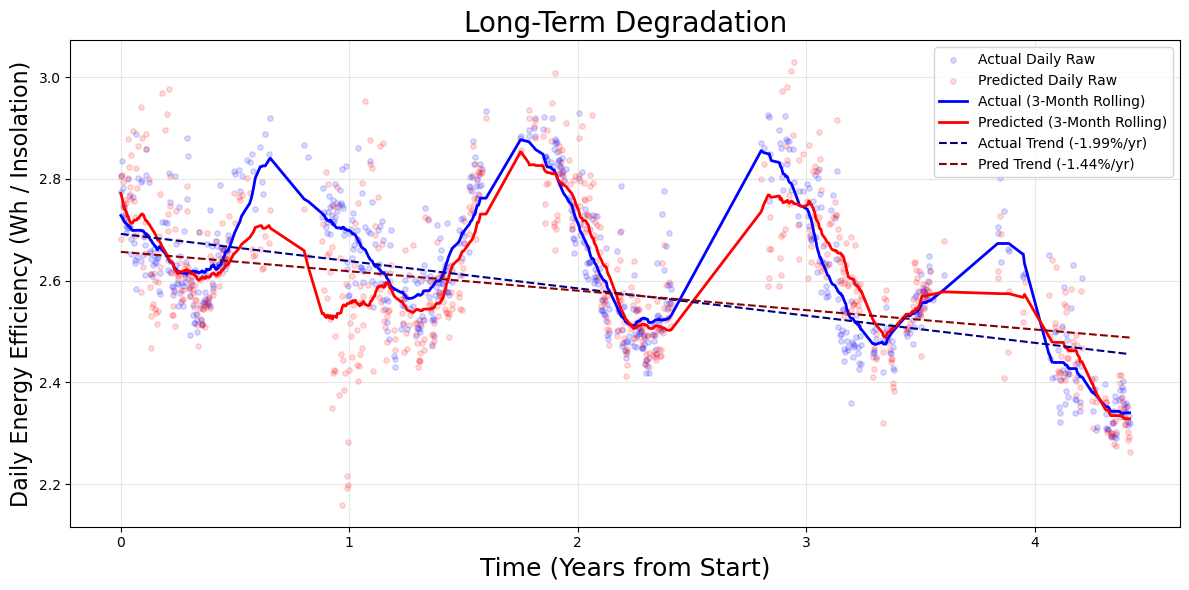


--- Seasonal MAE ---
season
Winter     59.823429
Spring    100.735411
Summer     45.358188
Autumn     53.267864
Name: error, dtype: float64


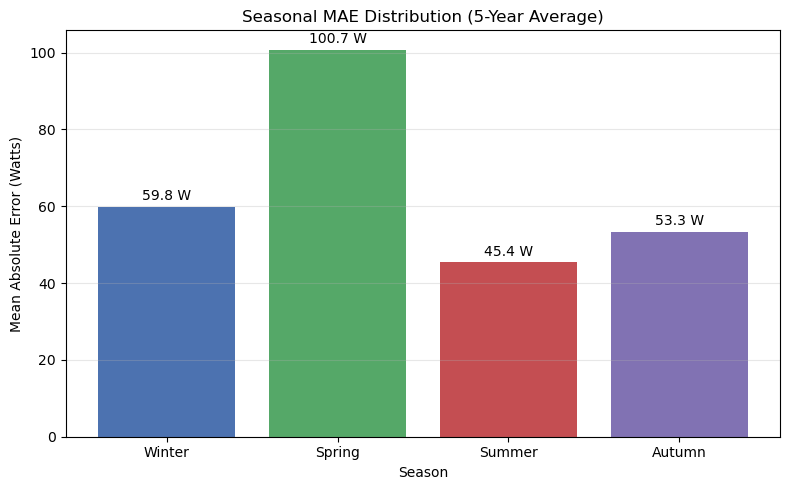

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import HuberRegressor
from scipy.stats import zscore

# ==========================================
# 1. Load and Merge Data
# ==========================================
print("Loading data...")

# Load Predictions
results = pd.read_csv("predictions_5year_new.csv")

# --- FIX: ROBUST DATE PARSING ---
results['date'] = pd.to_datetime(results['date'], dayfirst=True, format='mixed')

# Load Weather Data
try:
    weather = pd.read_csv("INES_filtered_new.csv")
    weather['date'] = pd.to_datetime(weather['date'], dayfirst=True, format='mixed')
except FileNotFoundError:
    print("Error: Weather file 'INES_filtered_PVlib.csv' not found.")
    exit()

# Merge
if 'hour' in weather.columns and 'hour' in results.columns:
    data = pd.merge(results, weather[['date', 'hour', 'Gsw']], on=['date', 'hour'], how='inner')
else:
    data = pd.merge(results, weather, on=['date', 'hour'], how='inner')

# ==========================================
# 2. Energy Integration (Hourly -> Daily)
# ==========================================
daily = data.groupby('date').agg({
    'P_actual': 'sum',
    'P_predicted': 'sum',
    'Gsw': 'sum'
}).reset_index()

daily = daily.rename(columns={
    'P_actual': 'Energy_Actual_Wh',
    'P_predicted': 'Energy_Predicted_Wh',
    'Gsw': 'Insolation_Wh_m2' 
})

# ==========================================
# 3. Calculate Energy Efficiency
# ==========================================
daily['Eff_Actual'] = daily['Energy_Actual_Wh'] / (daily['Insolation_Wh_m2'] + 1e-6)
daily['Eff_Predicted'] = daily['Energy_Predicted_Wh'] / (daily['Insolation_Wh_m2'] + 1e-6)

# ==========================================
# 4. STRICT Filtering (Updated)
# ==========================================
# Calculate Time Axis relative to the START of the dataset (Day 0)
global_start_date = daily['date'].min()
daily['time_years'] = (daily['date'] - global_start_date).dt.days / 365.25

# --- FILTERING STEPS ---
daily_filtered = daily[
    (daily['Insolation_Wh_m2'] > 3500) &    # 1. Only sunny days (High Quality)
    (daily['Energy_Actual_Wh'] > 100)    # 2. Remove Days with NO Data/Outages
    ].copy()

# 4. Physical Bounds Filter
daily_filtered = daily_filtered[
    (daily_filtered['Eff_Actual'] > 1.5) & 
    (daily_filtered['Eff_Actual'] < 4.5)
]

# 5. Strict Z-Score Cleaning
daily_filtered = daily_filtered[np.abs(zscore(daily_filtered['Eff_Actual'])) < 2.0]

# Set date as index for time-based rolling
daily_filtered = daily_filtered.set_index('date').sort_index()

# ==========================================
# 5. Smoothing & Weighted Huber Regression
# ==========================================
# --- 3-MONTH ROLLING AVERAGE ---
daily_filtered['Eff_Actual_Smooth'] = daily_filtered['Eff_Actual'].rolling('90D', center=True, min_periods=10).mean()
daily_filtered['Eff_Predicted_Smooth'] = daily_filtered['Eff_Predicted'].rolling('90D', center=True, min_periods=10).mean()

# Drop NaNs
analysis_df = daily_filtered.dropna(subset=['Eff_Actual_Smooth', 'Eff_Predicted_Smooth']).copy()

X = analysis_df[['time_years']].values

# Weight by Insolation 
weights = analysis_df['Insolation_Wh_m2'].values / analysis_df['Insolation_Wh_m2'].max()

def get_trend(y_series):
    huber = HuberRegressor()
    huber.fit(X, y_series, sample_weight=weights)
    slope = huber.coef_[0]
    intercept = huber.intercept_
    deg_rate = (slope / intercept) * 100 
    return deg_rate, huber.predict(X)

rate_actual, trend_actual = get_trend(analysis_df['Eff_Actual_Smooth'])
rate_predicted, trend_predicted = get_trend(analysis_df['Eff_Predicted_Smooth'])

print(f"\n=== DEGRADATION RESULTS ===")
print(f"Actual Degradation:    {rate_actual:.3f} % / year")
print(f"Predicted Degradation: {rate_predicted:.3f} % / year")

# ==========================================
# 6. Visualization 1: Energy Degradation
# ==========================================
plt.figure(figsize=(12, 6))

# Plot Raw (Faint)
plt.scatter(analysis_df['time_years'], analysis_df['Eff_Actual'], 
            alpha=0.15, color='blue', label='Actual Daily Raw', s=15)
plt.scatter(analysis_df['time_years'], analysis_df['Eff_Predicted'], 
            alpha=0.15, color='red', label='Predicted Daily Raw', s=15)

# Plot Smoothed (Solid)
plt.plot(analysis_df['time_years'], analysis_df['Eff_Actual_Smooth'], 
         color='blue', linewidth=2, label='Actual (3-Month Rolling)')
plt.plot(analysis_df['time_years'], analysis_df['Eff_Predicted_Smooth'], 
         color='red', linewidth=2, label='Predicted (3-Month Rolling)')

# Plot Trends (Dashed)
plt.plot(analysis_df['time_years'], trend_actual, color='navy', linewidth=1.5, linestyle='--',
         label=f'Actual Trend ({rate_actual:.2f}%/yr)')
plt.plot(analysis_df['time_years'], trend_predicted, color='darkred', linewidth=1.5, linestyle='--',
         label=f'Pred Trend ({rate_predicted:.2f}%/yr)')

plt.title("Long-Term Degradation", size = 20)
plt.xlabel("Time (Years from Start)", size = 18)
plt.ylabel("Daily Energy Efficiency (Wh / Insolation)", size = 16)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("degradation_energy_weighted.png")
plt.show()

# ==========================================
# 7. Visualization 2: Seasonal MAE Distribution
# ==========================================
# Calculate error on the FULL dataset (or filtered, depending on preference)
# Usually seasonal analysis is better on the full dataset to see all weather types
data['error'] = np.abs(data['P_actual'] - data['P_predicted'])

def get_season(dt):
    m = dt.month
    if m in [12, 1, 2]: return 'Winter'
    elif m in [3, 4, 5]: return 'Spring'
    elif m in [6, 7, 8]: return 'Summer'
    else: return 'Autumn'

data['season'] = data['date'].apply(get_season)

seasonal_mae = data.groupby('season')['error'].mean().reindex(['Winter', 'Spring', 'Summer', 'Autumn'])

print("\n--- Seasonal MAE ---")
print(seasonal_mae)

plt.figure(figsize=(8, 5))
bars = plt.bar(seasonal_mae.index, seasonal_mae.values, color=['#4c72b0', '#55a868', '#c44e52', '#8172b3'])

for bar in bars:
    yval = bar.get_height()
    if not np.isnan(yval):
        plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.1f} W', ha='center', va='bottom', fontsize=10)

plt.title("Seasonal MAE Distribution (5-Year Average)")
plt.ylabel("Mean Absolute Error (Watts)")
plt.xlabel("Season")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig("seasonal_mae_distribution.png")
plt.show()

## Benchmark PVWatts

Loading datasets...
Merging data...
Filtering for 2023-2024 for visualization...


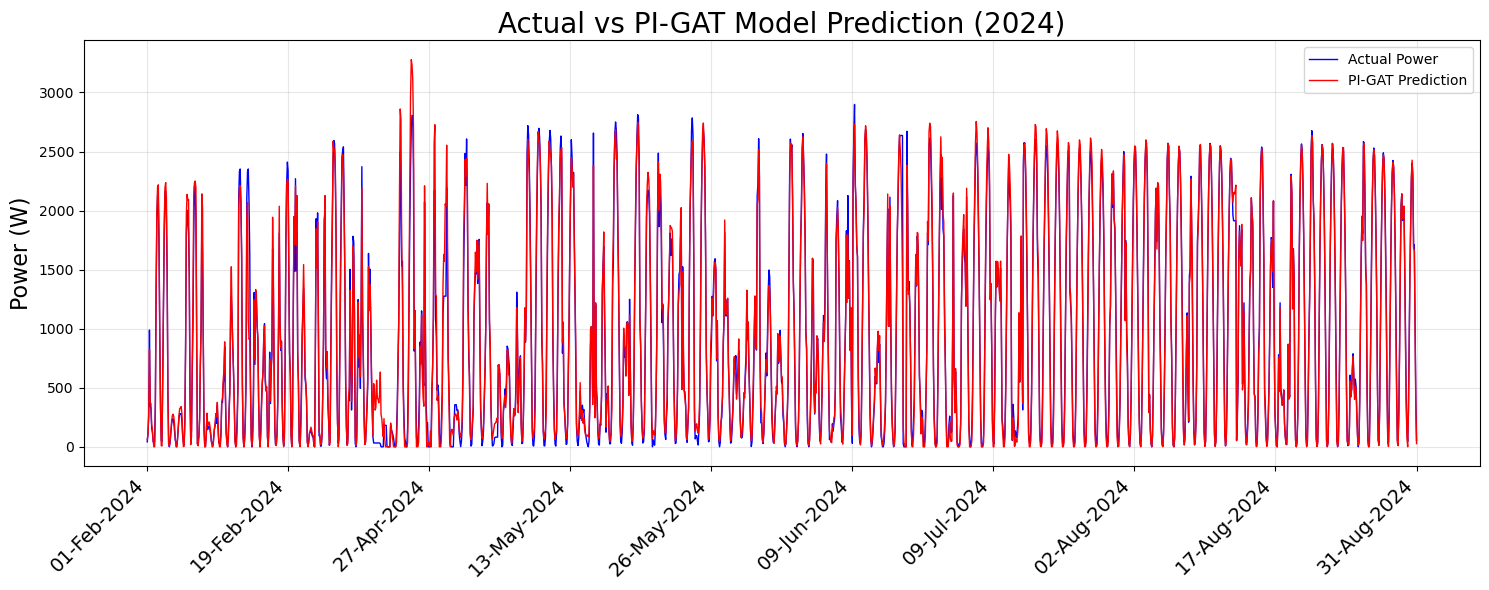

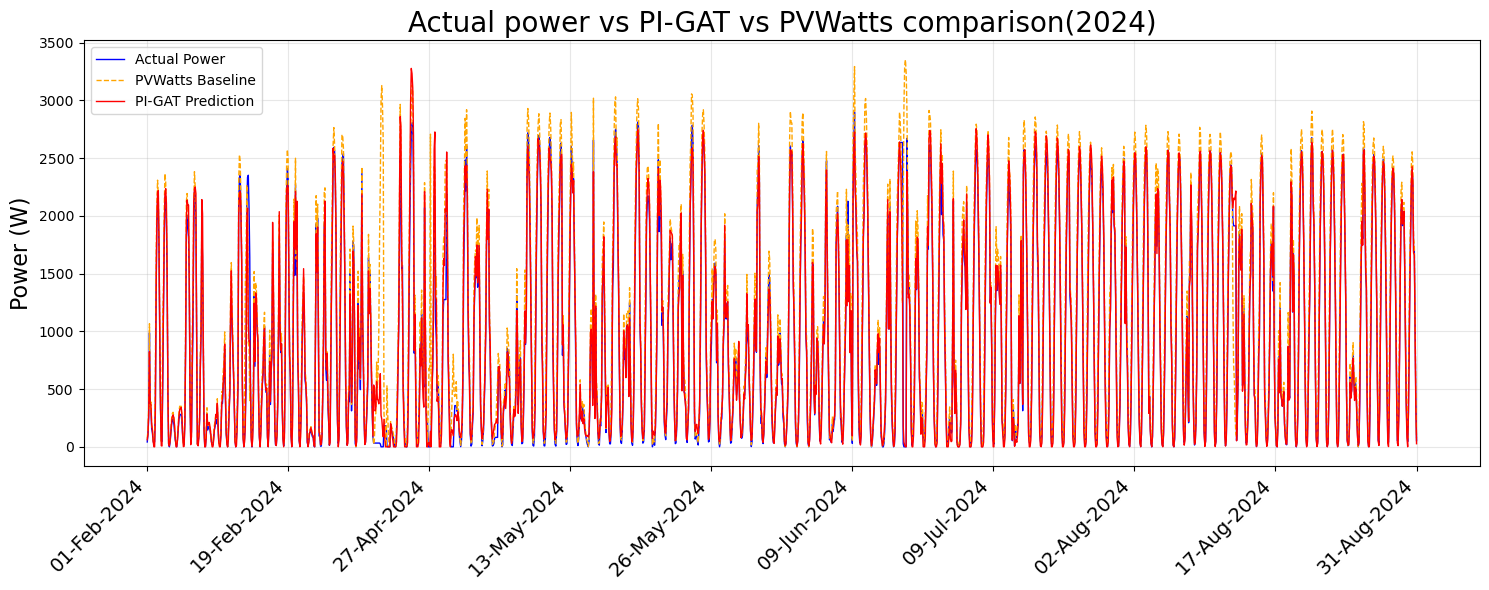

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ==========================================
# 1. Load Data
# ==========================================
print("Loading datasets...")
# 1. Load your PI-GAT model predictions
df_gnn = pd.read_csv("predictions_5year_final.csv")

# 2. Load the original dataset containing PVWatts predictions
df_pvwatts = pd.read_csv("INES_filtered_PVlib.csv")

# ==========================================
# 2. Preprocessing for Merge
# ==========================================
# Convert date columns to datetime objects
df_gnn['date'] = pd.to_datetime(df_gnn['date'])
df_pvwatts['date'] = pd.to_datetime(df_pvwatts['date'])

# Ensure 'hour' columns are integers for clean merging
if 'hour' in df_gnn.columns:
    df_gnn['hour'] = df_gnn['hour'].astype(int)

if 'hour' in df_pvwatts.columns:
    df_pvwatts['hour'] = df_pvwatts['hour'].astype(int)
else:
    print("Warning: 'hour' column not found in PVWatts file. Attempting to extract from date/time.")
    pass 

# ==========================================
# 3. Merge Datasets
# ==========================================
print("Merging data...")
merged_df = pd.merge(
    df_gnn, 
    df_pvwatts[['date', 'hour', 'P_pvwatts_dc']], # Only take the columns we need
    on=['date', 'hour'], 
    how='inner' # Keep only timestamps where we have BOTH predictions
)

# Create a single datetime column for sorting
merged_df['datetime'] = merged_df['date'] + pd.to_timedelta(merged_df['hour'], unit='h')
merged_df = merged_df.sort_values('datetime')

# ==========================================
# 5. Metrics Calculation Function
# ==========================================
def calculate_metrics(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    # MAPE: Filter out zero values to avoid division by zero
    # Also filtering out very small values (e.g. < 10W) to avoid exploding MAPE
    mask = y_true > 10 
    if np.sum(mask) > 0:
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    else:
        mape = np.nan
        
    return {
        "Model": model_name,
        "MAE (W)": mae,
        "MSE (W^2)": mse,
        "RMSE (W)": rmse,
        "R^2": r2,
        "MAPE (%)": mape
    }

# Calculate metrics for both models on the FULL dataset
# Using P_actual as ground truth
metrics_gnn = calculate_metrics(merged_df['P_actual'], merged_df['P_predicted'], "PI-GAT (GNN)")
metrics_pvwatts = calculate_metrics(merged_df['P_actual'], merged_df['P_pvwatts_dc'], "PVWatts")

# ==========================================
# 4. Filter for Years 2023-2024 (For Visualization)
# ==========================================
print("Filtering for 2023-2024 for visualization...")
df_plot = merged_df[merged_df['date'].dt.year.isin([2024])].copy()
# Reset index to ensure sequential plotting
df_plot = df_plot.reset_index(drop=True)

if df_plot.empty:
    print("Error: No data found for years 2023-2024. Check your dataset date range.")
    print(f"Available date range: {merged_df['date'].min()} to {merged_df['date'].max()}")

# ==========================================
# 6. Plotting (Sequential Index to avoid spikes)
# ==========================================

def plot_sequential(ax, df, y_columns, colors, labels, linestyles, title):
    # Use sequential index for x-axis to avoid gaps
    x_seq = np.arange(len(df))
    
    for col, color, label, style in zip(y_columns, colors, labels, linestyles):
        ax.plot(x_seq, df[col], label=label, color=color, linewidth=1, linestyle=style)

    ax.set_title(title, fontsize=20)
    ax.set_ylabel("Power (W)",fontsize=16)

    
    # Custom X-axis formatting
    # Show ~10 ticks spanning the range
    n_ticks = 10
    if len(df) > 0:
        tick_indices = np.linspace(0, len(df) - 1, n_ticks, dtype=int)
        tick_labels = df.iloc[tick_indices]['datetime'].dt.strftime('%d-%b-%Y')
        
        ax.set_xticks(tick_indices)
        ax.set_xticklabels(tick_labels, rotation=45, ha='right', size=14)
    ax.grid(True, alpha=0.3)
    ax.legend()

# --- PLOT 1: Actual vs PI-GAT (2023-2024) ---
plt.figure(figsize=(15, 6))
plot_sequential(
    plt.gca(), 
    df_plot, 
    ['P_actual', 'P_predicted'], 
    ['blue', 'red'], 
    ['Actual Power', 'PI-GAT Prediction'],
    ['-', '-'],
    "Actual vs PI-GAT Model Prediction (2024)"
)
plt.tight_layout()
plt.savefig("plot_actual_vs_pigat_2023_24.png")
plt.show()

# --- PLOT 2: Actual vs PI-GAT vs PVWatts (2023-2024) ---
plt.figure(figsize=(15, 6))
plot_sequential(
    plt.gca(), 
    df_plot, 
    ['P_actual', 'P_pvwatts_dc', 'P_predicted'], 
    ['blue', 'orange', 'red'], 
    ['Actual Power', 'PVWatts Baseline', 'PI-GAT Prediction'], 
    ['-', '--', '-'],
    "Actual power vs PI-GAT vs PVWatts comparison(2024)"
)
plt.tight_layout()
plt.savefig("plot_actual_vs_pigat_vs_pvwatts_2023_24.png")
plt.show()
